In [ ]:
import torch
import os
import cv2
import yaml
import matplotlib.pyplot as plt
from collections import defaultdict
import random
%pip install ultralytics
%pip install -U ipywidgets
from ultralytics import YOLO
import numpy as np
import random
import pandas as pd
!wandb disabled

## Configuration

In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
YOLO_MODEL = 'yolov8n.pt'
YAML_PATH = "/kaggle/input/shoplifting/data.yaml"
IMAGE_SIZE = 1024
EPOCHS = 40
BATCH = 32

## Load Yaml Paths

In [3]:
# Define paths to the labels for each dataset
root = "/kaggle/input/shoplifting"

datasets = ['train', 'valid']

image_dirs = {ds: f'{root}/{ds}/images' for ds in datasets}
label_dirs = {ds: f'{root}/{ds}/labels' for ds in datasets}

# Path to the YAML file
yaml_file = f'{root}/data.yaml'

# Load the YAML file
with open(yaml_file, 'r') as file:
    data = yaml.safe_load(file)

# Extract class names
class_names = data.get('names', [])

# Add 'no_class' to the class names
class_names.append('no_detection')

print("Class names:", class_names)

Class names: ['EmptyHands', 'droping', 'picking-hold', 'shoplifting', 'no_detection']


## Display Dataset and Class Count 

Train set: 2374 images (80.91%) of total
Valid set: 560 images (19.09%) of total


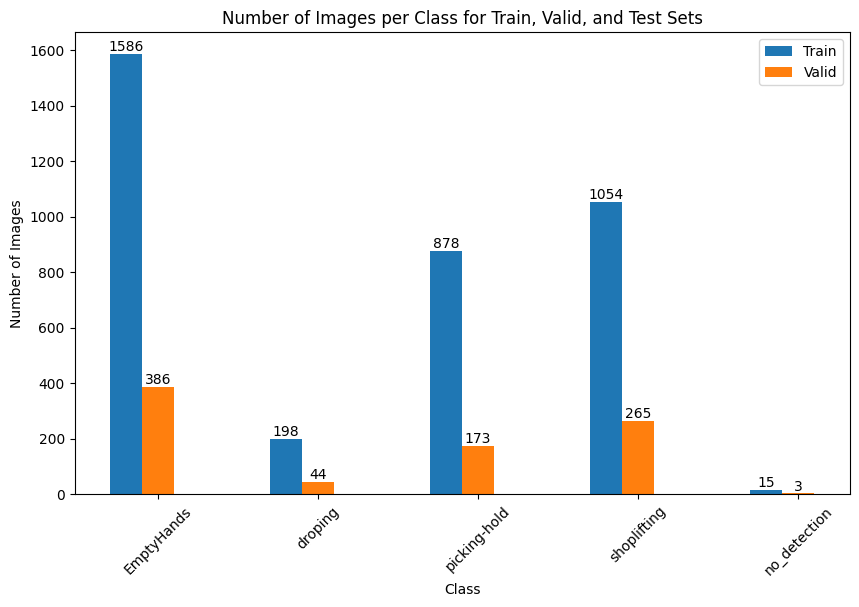

In [4]:
# Function to count the number of images per class and count files with no labels
def count_images_per_class(label_dir):
    class_counts = defaultdict(int)
    no_class_count = 0  # Counter for files with no labels
    total_files = len(os.listdir(label_dir))  # Total number of files in the directory
    for label_file in os.listdir(label_dir):
        label_path = os.path.join(label_dir, label_file)
        with open(label_path, 'r') as f:
            lines = f.readlines()
            if not lines:  # Check if the file is empty (no labels)
                no_class_count += 1
            else:
                for line in lines:
                    # YOLO label format: class_id, x_center, y_center, width, height (all normalized)
                    class_id = int(line.split()[0])  # The class_id is the first value in each label line
                    class_counts[class_id] += 1
    return class_counts, no_class_count, total_files

# Initialize a dictionary to store class counts and total files for each dataset
dataset_class_counts = {}
dataset_total_files = {}

# Count class occurrences for train, valid, and test
for dataset, label_dir in label_dirs.items():
    class_counts, no_class_count, total_files = count_images_per_class(label_dir)
    # Include the no_class_count in the results
    class_counts[len(class_names)-1] = no_class_count  # 'no_class' is the last class
    dataset_class_counts[dataset] = class_counts
    dataset_total_files[dataset] = total_files

# Plot the number of images per class for each dataset
def plot_class_distribution(dataset_class_counts, class_names):
    datasets = list(dataset_class_counts.keys())
    class_ids = range(len(class_names))
    
    # Prepare data for plotting
    width = 0.2  # Width of each bar
    x = list(class_ids)  # Class indices for x-axis
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for i, dataset in enumerate(datasets):
        # Get the class counts for this dataset
        class_frequencies = [dataset_class_counts[dataset].get(class_id, 0) for class_id in class_ids]
        # Plot the bar chart for this dataset with a slight offset for each dataset
        bars = ax.bar([p + i * width for p in x], class_frequencies, width=width, label=dataset.capitalize())
        
        # Add numbers on top of bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{int(height)}', ha='center', va='bottom')

    # Configure the x-axis and labels
    ax.set_xlabel('Class')
    ax.set_ylabel('Number of Images')
    ax.set_title('Number of Images per Class for Train, Valid, and Test Sets')
    ax.set_xticks([p + width for p in x])
    ax.set_xticklabels(class_names)
    ax.legend()

    plt.xticks(rotation=45)
    plt.show()

# Print percentages of train, valid, and test data
total_images = sum(dataset_total_files.values())
for dataset in dataset_total_files:
    percentage = (dataset_total_files[dataset] / total_images) * 100
    print(f'{dataset.capitalize()} set: {dataset_total_files[dataset]} images ({percentage:.2f}%) of total')

# Plot the class distribution across train, valid, and test datasets
plot_class_distribution(dataset_class_counts, class_names)

## Display Samples

Displaying images for class 'shoplifting':


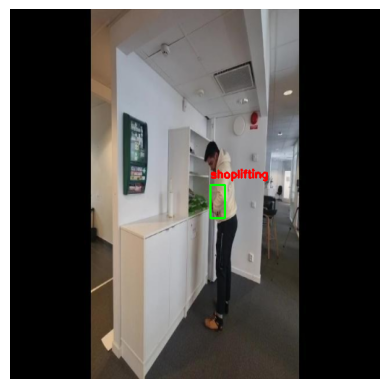

Displaying images for class 'EmptyHands':


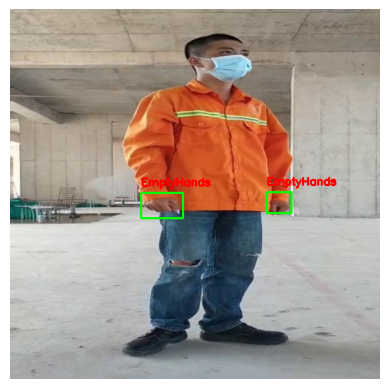

Displaying images for class 'picking-hold':


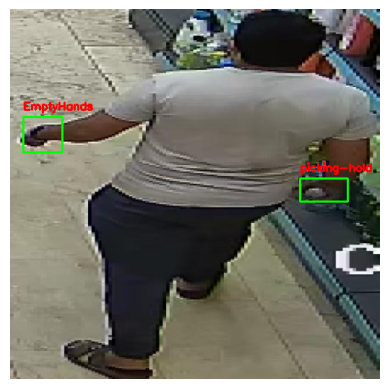

Displaying images for class 'droping':


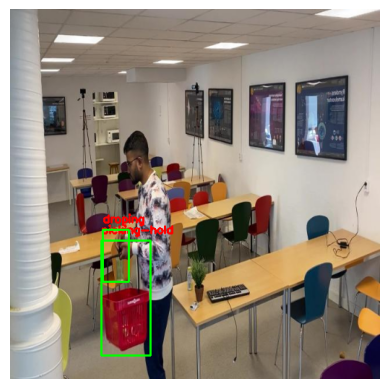

Displaying images for class 'no_detection':


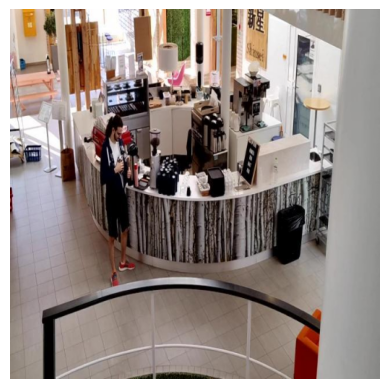

In [5]:
# Define paths to the images and labels
image_dir = image_dirs['train']
label_dir = label_dirs['train']

resize_dim = (IMAGE_SIZE, IMAGE_SIZE)
images_per_class = 1

# Helper function to load labels and classify images
def load_labels(label_dir):
    class_images = defaultdict(list)
    no_class_images = []

    for label_file in os.listdir(label_dir):
        label_path = os.path.join(label_dir, label_file)
        img_file = label_file.replace('.txt', '.jpg').replace('.png', '.jpg')  # Adjust if needed
        
        if not os.path.isfile(os.path.join(image_dir, img_file)):
            continue  # Skip if the corresponding image does not exist

        with open(label_path, 'r') as f:
            lines = f.readlines()
            if not lines:
                no_class_images.append(img_file)
            else:
                for line in lines:
                    class_id = int(line.split()[0])
                    class_images[class_id].append(img_file)
                    
    return class_images, no_class_images

# Helper function to plot images with bounding boxes
def plot_image_with_boxes(img_path, label_path):
    # Load image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib

    # Resize the image to 512x512
    resize_dim = (512, 512)
    img_resized = cv2.resize(img, resize_dim)

    # Load label and plot bounding boxes (adjusting for resized image)
    resized_h, resized_w = resize_dim
    with open(label_path, 'r') as f:
        for line in f.readlines():
            values = line.strip().split()
            
            # Check if the label line has the expected number of values
            if len(values) != 5:
                print(f"Unexpected label format in line: {line}")
                continue  # Skip this line

            try:
                class_id, x_center, y_center, width, height = map(float, values)
            except ValueError as e:
                print(f"Error parsing line: {line}. Error: {e}")
                continue

            # Convert normalized coordinates to actual image coordinates (adjusted to resized dimensions)
            x_center *= resized_w
            y_center *= resized_h
            width *= resized_w
            height *= resized_h
            x1 = int(x_center - width / 2)
            y1 = int(y_center - height / 2)
            x2 = int(x_center + width / 2)
            y2 = int(y_center + height / 2)

            # Draw rectangle
            cv2.rectangle(img_resized, (x1, y1), (x2, y2), (0, 255, 0), 2)
            
            # Display class name on the bounding box (you must have `class_names` defined somewhere)
            class_name = class_names[int(class_id)]
            cv2.putText(img_resized, class_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Display the resized image
    plt.imshow(img_resized)
    plt.axis('off')
    plt.show()

# Load labels and organize images
class_images, no_class_images = load_labels(label_dir)

# Randomly pick three images from each class and no detection
sampled_images = {}

# Sample images from each class
for class_id, images in class_images.items():
    class_name = class_names[class_id]
    sampled_images[class_name] = random.sample(images, min(images_per_class, len(images)))

# Sample images with no labels
sampled_images['no_detection'] = random.sample(no_class_images, min(images_per_class, len(no_class_images)))

# Display the sampled images
for class_name, images in sampled_images.items():
    print(f"Displaying images for class '{class_name}':")
    for img_file in images:
        img_path = os.path.join(image_dir, img_file)
        label_path = os.path.join(label_dir, img_file.replace('.jpg', '.txt').replace('.png', '.txt'))
        plot_image_with_boxes(img_path, label_path)

## Train Model

In [15]:
model = YOLO(YOLO_MODEL)

# Train the model
results = model.train(
    data=YAML_PATH,
    imgsz=IMAGE_SIZE,
    device=DEVICE,
    epochs=EPOCHS,
    batch=BATCH,
    box=3.5,
    cls=0.5,
    pose=0.0,
    kobj=0.0,
)

Ultralytics YOLOv8.2.103 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/input/shoplifting/data.yaml, epochs=40, time=None, patience=100, batch=32, imgsz=1024, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, sho

train: Scanning /kaggle/input/shoplifting/train/labels... 2374 images, 15 backgrounds, 0 corrupt: 100%|██████████| 2374/2374 [00:03<00:00, 698.90it/s]

train: WARNING ⚠️ Cache directory /kaggle/input/shoplifting/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/input/shoplifting/valid/labels... 560 images, 3 backgrounds, 0 corrupt: 100%|██████████| 560/560 [00:00<00:00, 797.99it/s]


val: WARNING ⚠️ Cache directory /kaggle/input/shoplifting/valid is not writeable, cache not saved.
Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to runs/detect/train3
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      11.2G      1.007      5.157      1.863         12       1024: 100%|██████████| 75/75 [00:53<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.37it/s]

                   all        560        868      0.929     0.0188      0.124     0.0472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      10.9G     0.9697      3.709      1.818         10       1024: 100%|██████████| 75/75 [00:52<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]

                   all        560        868      0.668      0.198      0.178     0.0669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      10.9G     0.9701      2.882      1.807         10       1024: 100%|██████████| 75/75 [00:51<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:06<00:00,  1.49it/s]

                   all        560        868      0.611       0.23      0.224     0.0837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      10.9G      0.981      2.494       1.82         12       1024: 100%|██████████| 75/75 [00:52<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.56it/s]

                   all        560        868      0.358      0.258       0.23     0.0753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      10.9G     0.9804      2.225      1.838         14       1024: 100%|██████████| 75/75 [00:52<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.74it/s]

                   all        560        868      0.446      0.332      0.297      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      10.9G     0.9658      2.069      1.823         20       1024: 100%|██████████| 75/75 [00:51<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.67it/s]

                   all        560        868      0.384      0.258      0.239     0.0812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      10.9G     0.9475      1.937      1.779         16       1024: 100%|██████████| 75/75 [00:52<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.68it/s]

                   all        560        868      0.496      0.439      0.433      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      10.9G     0.9458      1.831      1.786         24       1024: 100%|██████████| 75/75 [00:51<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.79it/s]

                   all        560        868      0.541      0.408      0.431      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      10.9G     0.9441      1.782      1.771         14       1024: 100%|██████████| 75/75 [00:52<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.57it/s]

                   all        560        868      0.507      0.439      0.417      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      10.9G     0.9297       1.76      1.763         14       1024: 100%|██████████| 75/75 [00:51<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.68it/s]

                   all        560        868      0.556      0.482      0.488      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      10.9G     0.9097      1.703       1.72          9       1024: 100%|██████████| 75/75 [00:51<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.76it/s]

                   all        560        868      0.542      0.465      0.453      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      10.9G     0.9107      1.617      1.713         16       1024: 100%|██████████| 75/75 [00:52<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.72it/s]

                   all        560        868      0.566      0.515      0.528      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      10.9G     0.8933      1.591      1.685         12       1024: 100%|██████████| 75/75 [00:52<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.62it/s]

                   all        560        868      0.613      0.497      0.514      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      10.9G     0.8982      1.534       1.71          6       1024: 100%|██████████| 75/75 [00:52<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.67it/s]

                   all        560        868      0.554      0.564      0.554      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      10.9G     0.8782      1.542      1.673         14       1024: 100%|██████████| 75/75 [00:52<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.66it/s]

                   all        560        868      0.548      0.535       0.52        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      10.9G     0.8878      1.494      1.684         12       1024: 100%|██████████| 75/75 [00:51<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.72it/s]

                   all        560        868      0.584      0.588      0.575       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      10.9G      0.872      1.465      1.659         12       1024: 100%|██████████| 75/75 [00:52<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.71it/s]

                   all        560        868      0.611       0.51      0.532      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      10.9G     0.8666      1.405      1.645          6       1024: 100%|██████████| 75/75 [00:51<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.75it/s]

                   all        560        868      0.652      0.515      0.571      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      10.9G     0.8686      1.399      1.655         12       1024: 100%|██████████| 75/75 [00:51<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.77it/s]

                   all        560        868      0.655      0.561      0.587      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      10.9G     0.8637      1.374      1.629         10       1024: 100%|██████████| 75/75 [00:51<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.67it/s]

                   all        560        868      0.697      0.512      0.601      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      10.9G     0.8506      1.335      1.627         10       1024: 100%|██████████| 75/75 [00:52<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.78it/s]

                   all        560        868      0.648      0.581      0.617      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      10.9G     0.8394      1.323       1.61          9       1024: 100%|██████████| 75/75 [00:51<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.69it/s]

                   all        560        868      0.624      0.571      0.602      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      10.9G     0.8478      1.337      1.631         12       1024: 100%|██████████| 75/75 [00:52<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.68it/s]

                   all        560        868      0.665      0.559      0.627      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      10.9G       0.83      1.275      1.584          8       1024: 100%|██████████| 75/75 [00:51<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.76it/s]

                   all        560        868      0.669      0.593       0.63      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      10.9G     0.8318      1.273      1.597         18       1024: 100%|██████████| 75/75 [00:52<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.74it/s]

                   all        560        868       0.68      0.599       0.64      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      10.9G     0.8253      1.223      1.572         15       1024: 100%|██████████| 75/75 [00:51<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.67it/s]

                   all        560        868      0.684      0.554      0.623      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      10.9G     0.8167      1.229      1.564         12       1024: 100%|██████████| 75/75 [00:52<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.77it/s]

                   all        560        868      0.733      0.603      0.659      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40      10.9G     0.8088      1.192      1.558         14       1024: 100%|██████████| 75/75 [00:52<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.74it/s]

                   all        560        868      0.753      0.607      0.652      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      10.9G      0.802      1.153      1.555         10       1024: 100%|██████████| 75/75 [00:52<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.71it/s]

                   all        560        868      0.778      0.582      0.673       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40      10.9G     0.8095      1.167      1.551          8       1024: 100%|██████████| 75/75 [00:51<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.77it/s]

                   all        560        868      0.729      0.639      0.685       0.28


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      11.6G     0.8103      1.099      1.613          8       1024: 100%|██████████| 75/75 [00:54<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.74it/s]

                   all        560        868      0.716      0.607      0.669      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      10.9G     0.7947      1.057      1.602         14       1024: 100%|██████████| 75/75 [00:51<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.79it/s]

                   all        560        868      0.725      0.619      0.687      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      10.9G     0.7884      1.037      1.595         12       1024: 100%|██████████| 75/75 [00:51<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.80it/s]

                   all        560        868      0.717      0.621      0.691      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      10.9G     0.7795      1.006      1.578          7       1024: 100%|██████████| 75/75 [00:51<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.80it/s]

                   all        560        868      0.739      0.591      0.677      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      10.9G     0.7675     0.9829      1.562         11       1024: 100%|██████████| 75/75 [00:51<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.78it/s]

                   all        560        868      0.714      0.635      0.678      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      10.9G     0.7676     0.9744      1.564          8       1024: 100%|██████████| 75/75 [00:51<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.70it/s]

                   all        560        868      0.726      0.624      0.673      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      10.9G     0.7524     0.9497      1.539         10       1024: 100%|██████████| 75/75 [00:51<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.83it/s]

                   all        560        868      0.672      0.685       0.69       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      10.9G      0.751     0.9493      1.544          8       1024: 100%|██████████| 75/75 [00:51<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.80it/s]

                   all        560        868      0.722      0.653      0.698      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      10.9G     0.7437      0.923      1.527         10       1024: 100%|██████████| 75/75 [00:51<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.82it/s]

                   all        560        868      0.705      0.646      0.701      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40      10.9G     0.7367     0.9157      1.509         10       1024: 100%|██████████| 75/75 [00:51<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.79it/s]

                   all        560        868      0.719      0.657      0.701      0.284



40 epochs completed in 0.654 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 6.3MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics YOLOv8.2.103 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 168 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]


                   all        560        868      0.726      0.653      0.696      0.285
            EmptyHands        230        386      0.772      0.699      0.748      0.304
               droping         44         44      0.633      0.432       0.48      0.138
          picking-hold        146        173      0.712      0.613      0.672        0.3
           shoplifting        263        265      0.786      0.868      0.885        0.4
Speed: 0.4ms preprocess, 5.6ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/detect/train3


In [18]:
csv_file = '/kaggle/working/runs/detect/train3/results.csv'

df = pd.read_csv(csv_file)

print(df.columns)

Index(['                  epoch', '         train/box_loss',
       '         train/cls_loss', '         train/dfl_loss',
       '   metrics/precision(B)', '      metrics/recall(B)',
       '       metrics/mAP50(B)', '    metrics/mAP50-95(B)',
       '           val/box_loss', '           val/cls_loss',
       '           val/dfl_loss', '                 lr/pg0',
       '                 lr/pg1', '                 lr/pg2'],
      dtype='object')


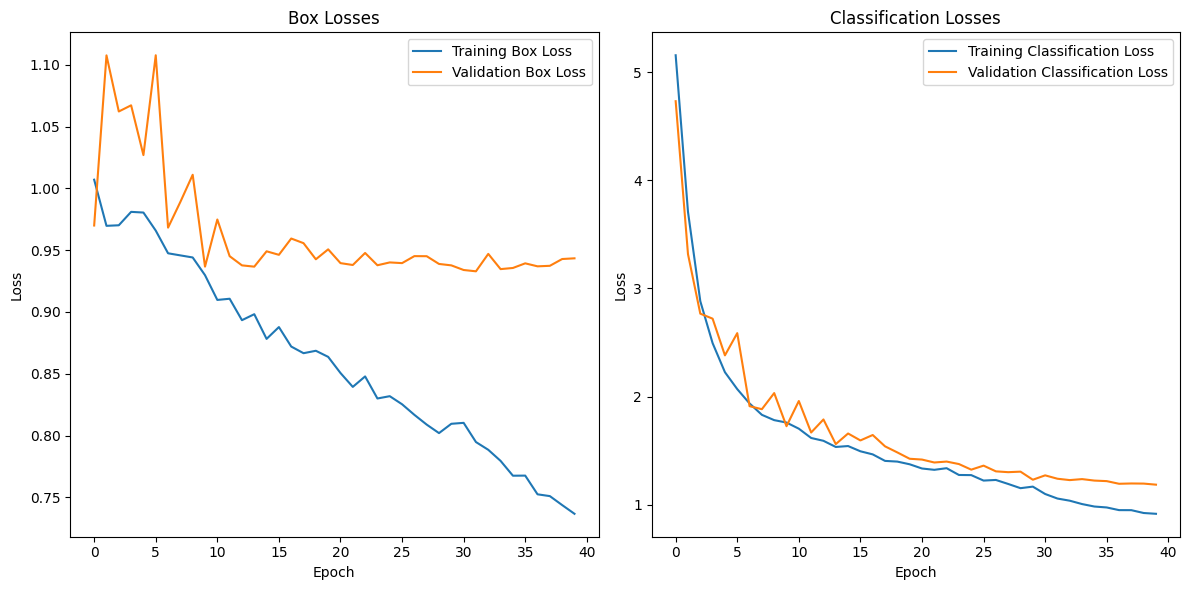

In [19]:
# Strip spaces from column names
df.columns = df.columns.str.strip()

# Create subplots: one for Box Loss and one for Classification Loss
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot Box Losses (Validation and Training) on the first subplot
axes[0].plot(df['train/box_loss'], label='Training Box Loss')
axes[0].plot(df['val/box_loss'], label='Validation Box Loss')

# Add labels, title, and legend for the Box Loss plot
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Box Losses')
axes[0].legend()

# Plot Classification Losses (Validation and Training) on the second subplot
axes[1].plot(df['train/cls_loss'], label='Training Classification Loss')
axes[1].plot(df['val/cls_loss'], label='Validation Classification Loss')

# Add labels, title, and legend for the Classification Loss plot
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Classification Losses')
axes[1].legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

## Predictions on Validation Set

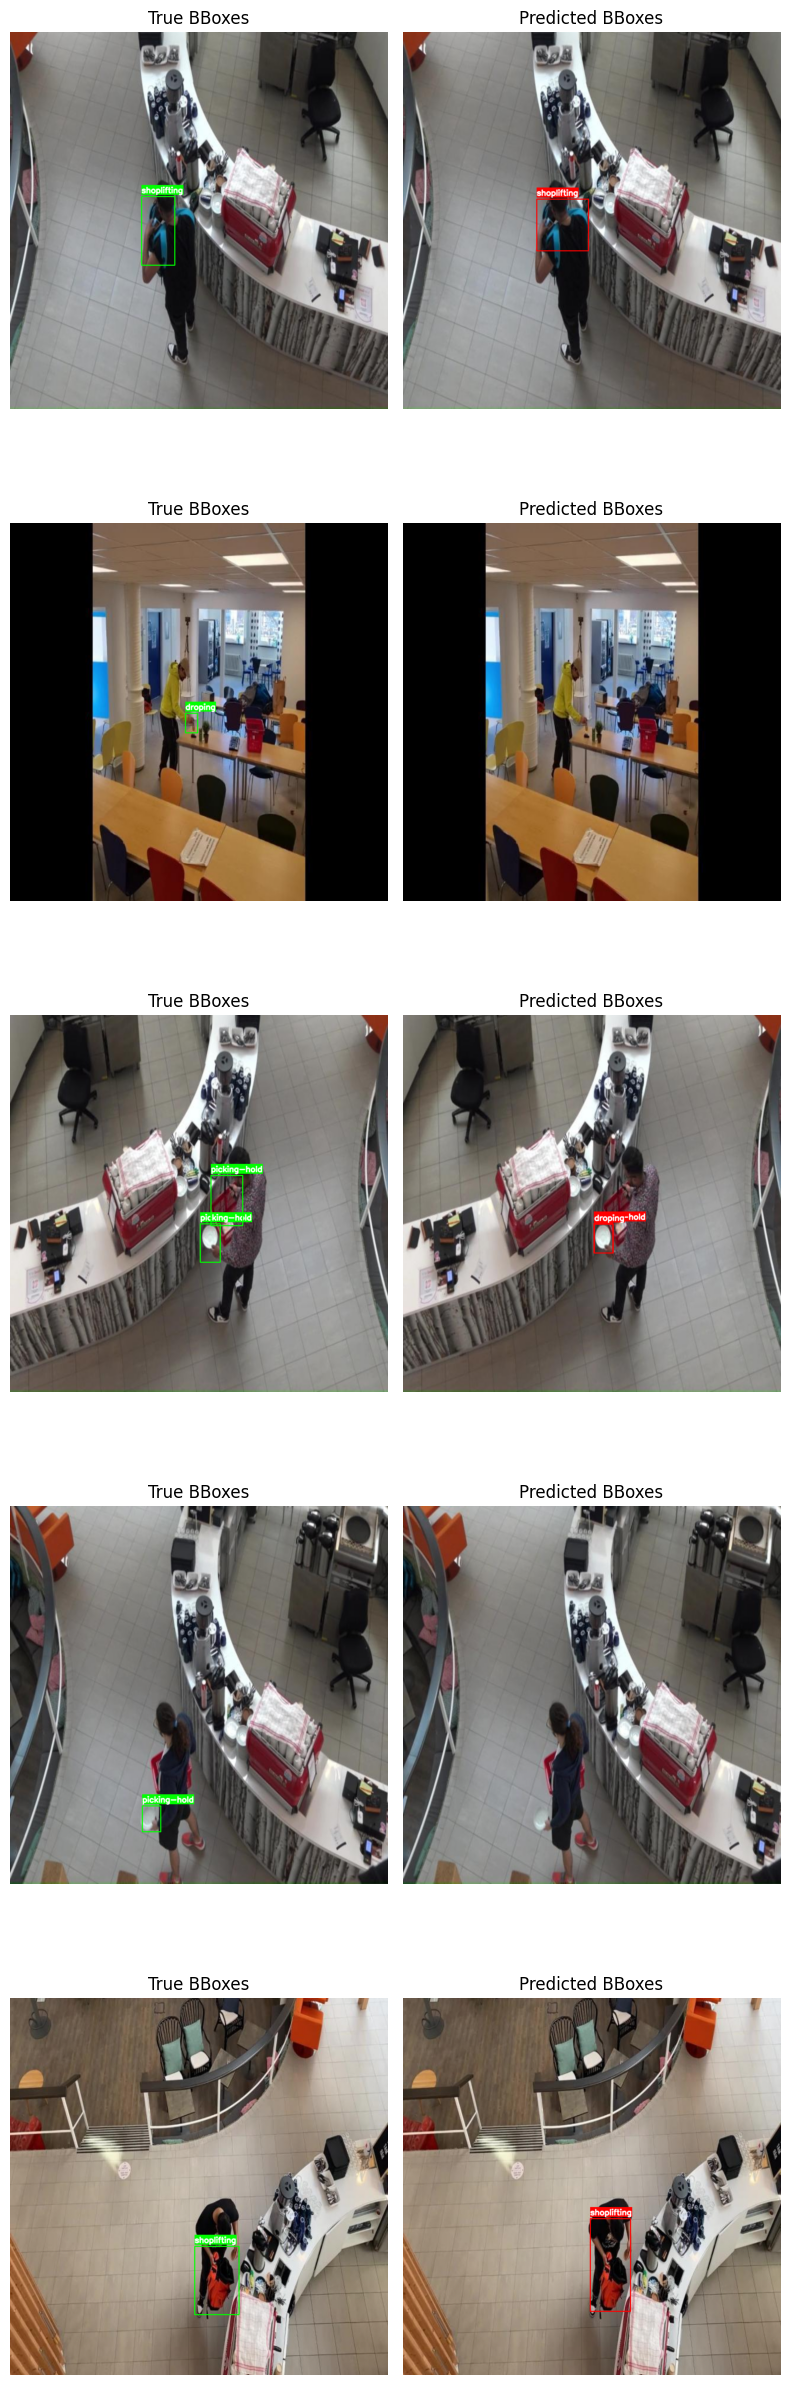

In [21]:
# Define paths
images_dir = image_dirs['valid']
labels_dir = label_dirs['valid']

images_to_select = 5

# Helper function to draw bounding boxes with highlighted class names
def draw_bboxes(img, bboxes, class_names, box_color=(0, 255, 0), text_color=(255, 255, 255), thickness=2, font_scale=0.7):
    img = img.copy()
    for bbox in bboxes:
        class_id, x_center, y_center, width, height = bbox
        x1 = int((x_center - width / 2) * img.shape[1])
        y1 = int((y_center - height / 2) * img.shape[0])
        x2 = int((x_center + width / 2) * img.shape[1])
        y2 = int((y_center + height / 2) * img.shape[0])
        
        # Draw bounding box
        img = cv2.rectangle(img, (x1, y1), (x2, y2), box_color, thickness)
        
        # Draw class name with a background rectangle
        class_name = class_names[class_id]
        text_size = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, font_scale, 1)[0]
        text_x = x1
        text_y = y1 - 10 if y1 - 10 > 10 else y1 + text_size[1] + 10  # Ensure text is within the image
        
        # Draw filled rectangle for background
        img = cv2.rectangle(img, (text_x, text_y - text_size[1] - 5), (text_x + text_size[0], text_y + 5), box_color, -1)
        
        # Put the text on top of the rectangle
        img = cv2.putText(img, class_name, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, text_color, thickness, cv2.LINE_AA)
    
    return img

# Randomly select images
image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg') or f.endswith('.png')]
selected_images = random.sample(image_files, images_to_select)

# Prepare figure for plotting
if len(selected_images) == 1:
    fig, axes = plt.subplots(1, 2, figsize=(8, 5))
    axes = np.expand_dims(axes, axis=0)  # Ensure axes is 2D when only 1 image is selected
else:
    fig, axes = plt.subplots(len(selected_images), 2, figsize=(8, 5 * len(selected_images)))

for i, image_file in enumerate(selected_images):
    # Load image
    img_path = os.path.join(images_dir, image_file)
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_LINEAR)
    
    # Load corresponding label file
    label_file = os.path.splitext(image_file)[0] + '.txt'
    label_path = os.path.join(labels_dir, label_file)
    
    true_bboxes = []
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()

                # Ensure that there are exactly 5 elements in the line (class_id, x_center, y_center, width, height)
                if len(parts) >= 5:
                    try:
                        # Unpack the first value as class_id and the next four as float coordinates
                        class_id = int(parts[0])
                        x_center, y_center, width, height = map(float, parts[1:5])

                        # Append the bounding box to the list
                        true_bboxes.append((class_id, x_center, y_center, width, height))
                    except ValueError as e:
                        # If any conversion fails, print an error message
                        print(f"Error processing line: {line}. Error: {e}")
                        continue
    
    # Predict with YOLO
    results = model(img_resized, verbose=False)
    preds = results[0].boxes
    pred_bboxes = []
    for pred in preds:
        x1, y1, x2, y2 = pred.xyxy[0].cpu().numpy()  # Extract box coordinates and class
        x_center = (x1 + x2) / 2 / img_resized.shape[1]
        y_center = (y1 + y2) / 2 / img_resized.shape[0]
        width = (x2 - x1) / img_resized.shape[1]
        height = (y2 - y1) / img_resized.shape[0]
        class_id = pred.cls[0].cpu().numpy() 
        pred_bboxes.append((int(class_id), x_center, y_center, width, height))
    
    # Draw true and predicted bounding boxes with highlighted text
    img_with_true_bboxes = draw_bboxes(img_resized, true_bboxes, class_names, box_color=(0, 255, 0), text_color=(255, 255, 255))
    img_with_pred_bboxes = draw_bboxes(img_resized, pred_bboxes, class_names, box_color=(255, 0, 0), text_color=(255, 255, 255))
    
    # Plot images
    axes[i, 0].imshow(img_with_true_bboxes)
    axes[i, 0].set_title(f'True BBoxes')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(img_with_pred_bboxes)
    axes[i, 1].set_title(f'Predicted BBoxes')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()